# Oracle SAT solver with 1 solution
### by Alessandro Berti


#### Satisfy to following 3-SAT
(x ∨ y) ∧ ¬y

### In QC, we know how to implement the AND operator -> (Multi-Controlled X gate)

##### De Morgan
¬(a ∧ b) = ¬a ∨ ¬b \
¬(a ∨ b) = ¬a ∧ ¬b

#### Let us rewrite (1)
$(x ∨ y) ∧ ¬y = $

$¬(¬x ∧ ¬y) ∧ ¬y$


and let us define $w_0$ and $w_1$ as:

$w_0 = ¬x ∧ ¬y$ 

$w_1 = ¬y$ 


Now the SAT instance is expressed in terms of only AND -> happy :)

Spoiler: the solution is 01 (order: yx)

Since we already know that exists a single solution, then the number of repetitions of (oracle-diffuser) is given by the formula: 

$\frac{\pi}{4} \sqrt{2^n}$, where $n$ is the number of variables, respectively $x, y$

In [75]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import MCXGate, HGate, XGate, MCPhaseGate, ZGate
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator

import math

## Diffuser

In [76]:
def get_diffuser(len_element):
    d = QuantumRegister(len_element, 'd')
    m = QuantumRegister(1, 'm')
    
    diffuser = QuantumCircuit(d, m, name='diffuser')
    
    for i in range(len(d)):
        diffuser.append(HGate(), [d[i]])
        diffuser.append(XGate(), [d[i]])
    
    MCZGate = ZGate().control(len(d))
    diffuser.append(MCZGate, d[0:]+[m])

    for i in range(len(d)):
        diffuser.append(XGate(), [d[i]])
        diffuser.append(HGate(), [d[i]])

    return diffuser

## Oracle

In [77]:
def get_oracle(n_var, steps):
    x = QuantumRegister(n_var, 'x')
    w = QuantumRegister(len(steps)-1, 'w')
    m = QuantumRegister(1, 'marker')
    
    oracle = QuantumCircuit(x, w, m, name='oracle')
    
    #step: w0 = (¬x_0 ∧ ¬x_1)
    oracle.append(MCXGate(len(steps[0]), label=steps[0], ctrl_state=steps[0]), [x[0]]+[x[1]]+[w[0]])
    oracle.barrier()

    #step: w1 = ¬x_1
    oracle.append(MCXGate(len(steps[1]), label=steps[1], ctrl_state=steps[1]), [x[1]]+[w[1]])
    oracle.barrier()

    #step: w2 = ¬(¬x_0 ∧ ¬x_1) ∧ ¬x_1
    MCZGate = ZGate().control(num_ctrl_qubits=len(steps[2]), label=steps[2], ctrl_state=steps[2])
    oracle.append(MCZGate, w[0:]+[m[0]])    
    oracle.barrier()
   
    
    #uncomputation step: w1 = ¬x_1
    oracle.append(MCXGate(len(steps[1]), label=steps[1], ctrl_state=steps[1]), [x[1]]+[w[1]])
    oracle.barrier()

    #uncomputation step: w0 = (¬x_0 ∧ ¬x_1)
    oracle.append(MCXGate(len(steps[0]), label=steps[0], ctrl_state=steps[0]), [x[0]]+[x[1]]+[w[0]])
    oracle.barrier()

    return oracle

# Quantum Circuit for the SAT instance

In [78]:
n = 2 #number of variables
steps = ['00', '0', '10']

q_x = QuantumRegister(1, 'x') # variable 1
q_y = QuantumRegister(1, 'y') # variable 2

q_w = QuantumRegister(len(steps)-1, 'w') #working qubits: for each clauses, 1 working qubit storing the result
marker = QuantumRegister(1, 'marker')

c_res = ClassicalRegister(n, 'res')

sat_solver = QuantumCircuit(q_x, q_y, q_w, marker, c_res)

# Step 0: Flip the marker qubit to enable destructive interferences

In [79]:
sat_solver.append(XGate(), [marker])

## Step 1: Generate all the possible assignments for the boolean formula 

In [80]:
sat_solver.append(HGate(), [q_x])
sat_solver.append(HGate(), [q_y])

## Step 2 - 3: Apply Oracle and Diffuser

In [81]:
repetitions = math.floor(math.pi/4 * math.sqrt(2**n))

for i in range(repetitions):
    sat_solver.append(get_oracle(n, steps), q_x[0:]+q_y[0:]+q_w[0:]+[marker])
    sat_solver.append(get_diffuser(n), q_x[0:]+q_y[0:]+[marker])

### Oracle Circuit

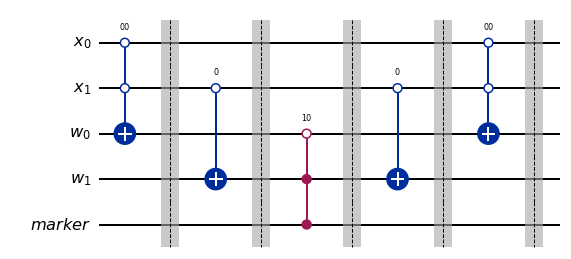

In [82]:
get_oracle(n, steps).draw(output='mpl')

### Diffuser Circuit

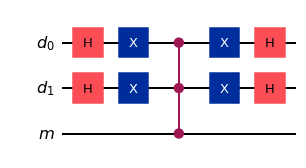

In [83]:
get_diffuser(n).draw(output='mpl')

## Step 4: Measurements

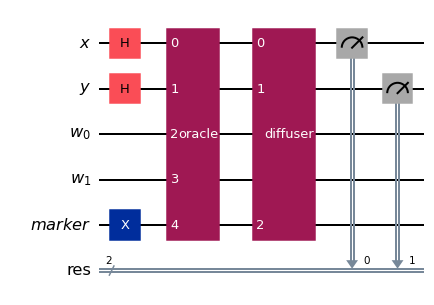

In [84]:
sat_solver.measure(q_x[0],c_res[0])
sat_solver.measure(q_y[0],c_res[1])


sat_solver.draw('mpl')

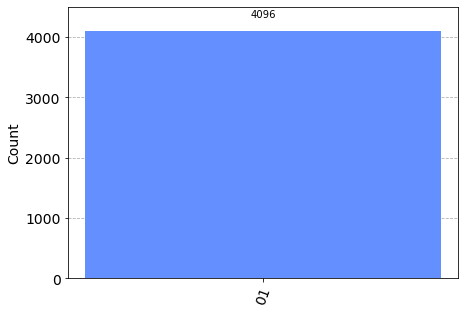

In [85]:
simulator = AerSimulator()  # Create a simulator backend
transpiled_sat_solver = transpile(sat_solver, simulator)
result = simulator.run(transpiled_sat_solver, shots=4096).result()  # Run the circuit and get the result
counts = result.get_counts()
plot_histogram(counts)

## The solution is:
- 01 \
(order: $yx$)